In [1]:
import logging

from utils import logging as lg


lg.set_logging(logging.DEBUG)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cmocean


tf.logging.set_verbosity(tf.logging.ERROR)

import math

from utils import data_provider
from utils import experiment_artifact
from utils import network_architecture

from notebook_utils import plot
from model import s2_network, s3_network, deep_4l_network, convdeep_4l_network, provider as model_provider

from heatmap_tutorial import modules, utils
import matplotlib.gridspec as gridspec

plot.setup()


2018-01-27 23:27:00,986 | DEBUG : plot.py(setup 16) - Setup plot parameters


# Preparation

## Data Loader

In [3]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist')
}

2018-01-27 23:27:00,993 | DEBUG : data_provider.py(get_mnist 22) - Load ../data/mnist : train
2018-01-27 23:27:01,395 | DEBUG : data_provider.py(get_mnist 22) - Load ../data/mnist : test
2018-01-27 23:27:01,716 | DEBUG : data_provider.py(get_mnist 22) - Load ../data/fashion-mnist : train
2018-01-27 23:27:02,102 | DEBUG : data_provider.py(get_mnist 22) - Load ../data/fashion-mnist : test


## Functions

In [4]:
def model_path(network, dataset, seq):
    return '../final-models/%s_network-%s-seq-%d' % (network, dataset, seq)

In [17]:
x = np.ones((3,28,28))
x[0,:,:] = x[0,:,:]*0
x[1,:,:] = -x[1,:,:]
print(x)
y = np.zeros((3, 10))
y[:, 0] = 1

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  ..., 
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]]

 [[ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  ..., 
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]]]


2018-01-27 23:32:22,138 | DEBUG : provider.py(load 10) - Load network from ../final-models/s2_network-mnist-seq-1
2018-01-27 23:32:22,143 | DEBUG : experiment_artifact.py(get_result 68) - Getting result 
{'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9783333539962769, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 's2_network-mnist-seq-1---2017-12-31--12-58-57', 'architecture_name': 's2_network', 'accuracy': 0.9812999963760376, 'dims': 28, 'lr': 0.0001, 'keep_prob': 0.5, 'architecture': 'hidden:768|out:10--recur:1', 'column_at_a_time': 28, 'max_seq_length': 28, 'dataset': 'mnist', 'batch': 50}
2018-01-27 23:32:22,144 | DEBUG : experiment_artifact.py(get_result 69) - {'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9783333539962769, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 's2_network-mnist-seq-1---2017-12-31--12-58-57', 'architecture_name': 's2_network', 'accuracy': 0.9812999963760376, 'dims': 28, 'lr': 0.0001, 'keep_prob': 0.5, 'ar

Relevance score for 0  : 0.0000
Relevance score for 1  : 38.1469
Relevance score for 2  : 61.3465
Relevance score for 0  : 0.0000
Relevance score for 1  : 0.0000
Relevance score for 2  : 0.0000


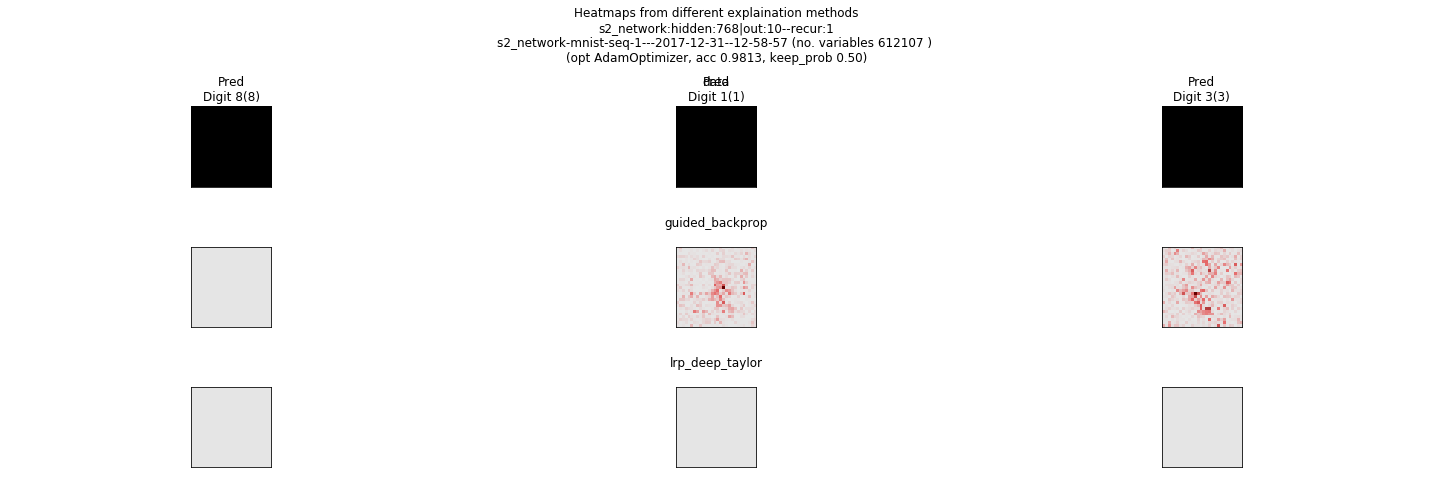

In [18]:
plot.plot_relevance_methods(model_path('s2', 'mnist', 1), dataset['mnist'], data=(x,y),
                            methods=['guided_backprop', 'lrp_deep_taylor'], verbose=True) 

2018-01-27 23:32:25,710 | DEBUG : provider.py(load 10) - Load network from ../final-models/s3_network-mnist-seq-1
2018-01-27 23:32:25,715 | DEBUG : experiment_artifact.py(get_result 68) - Getting result 
{'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9789166450500488, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 's3_network-mnist-seq-1---2017-12-31--13-46-18', 'architecture_name': 's3_network', 'accuracy': 0.9787999987602234, 'dims': 28, 'lr': 0.0001, 'keep_prob': 0.5, 'architecture': 'in1:512|hidden:256|out1:64|out2:10--recur:1', 'column_at_a_time': 28, 'max_seq_length': 28, 'dataset': 'mnist', 'batch': 50}
2018-01-27 23:32:25,716 | DEBUG : experiment_artifact.py(get_result 69) - {'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9789166450500488, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 's3_network-mnist-seq-1---2017-12-31--13-46-18', 'architecture_name': 's3_network', 'accuracy': 0.9787999987602234, 'dims': 28, 'lr': 0.0001, 'kee

Relevance score for 0  : 0.0000
Relevance score for 1  : 12.8852
Relevance score for 2  : 63.5539
Relevance score for 0  : 0.0000
Relevance score for 1  : 0.0000
Relevance score for 2  : 5.5973


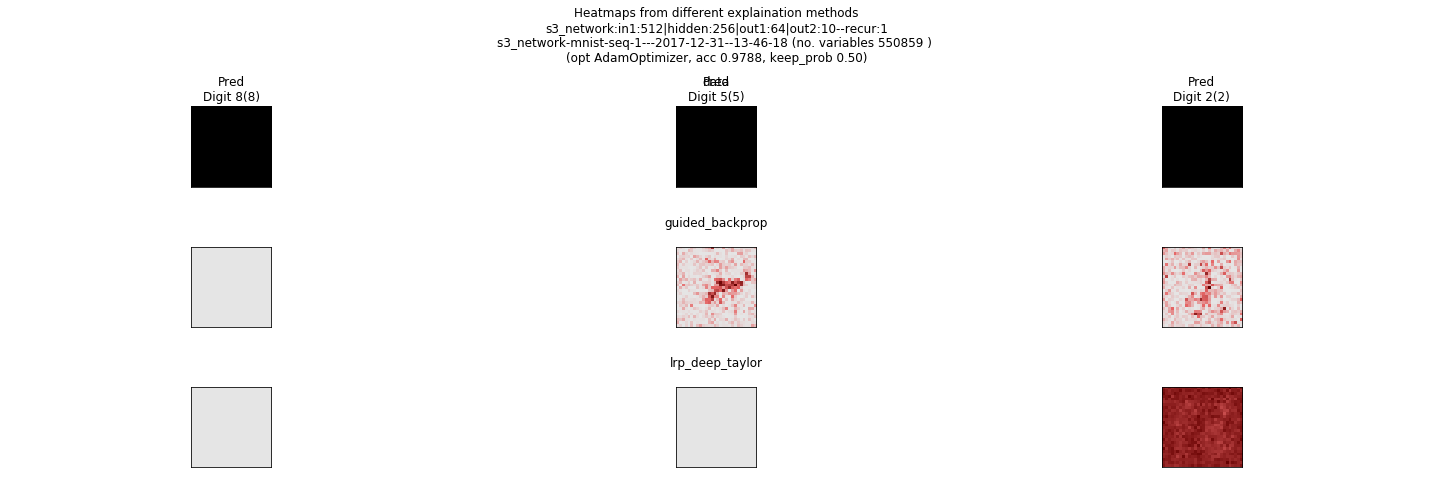

In [19]:
plot.plot_relevance_methods(model_path('s3', 'mnist', 1), dataset['mnist'], data=(x,y),
                            methods=['guided_backprop', 'lrp_deep_taylor'], verbose=True) 

2018-02-01 09:56:10,793 | DEBUG : provider.py(load 10) - Load network from ../final-models/deep_4l_network-mnist-seq-1
2018-02-01 09:56:10,867 | DEBUG : experiment_artifact.py(get_result 68) - Getting result 
{'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9775000214576721, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 'deep_4l_network-mnist-seq-1---2018-01-29--01-45-49', 'architecture_name': 'deep_4l_network', 'accuracy': 0.9789000153541565, 'dims': 28, 'lr': 0.0001, 'keep_prob': 0.5, 'architecture': 'in1:512|in2:256|hidden:128|out1:64|out2:10--recur:1', 'column_at_a_time': 28, 'max_seq_length': 28, 'dataset': 'mnist', 'batch': 50}
2018-02-01 09:56:10,868 | DEBUG : experiment_artifact.py(get_result 69) - {'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9775000214576721, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 'deep_4l_network-mnist-seq-1---2018-01-29--01-45-49', 'architecture_name': 'deep_4l_network', 'accuracy': 0.978900015354156

Relevance score for 0  : 0.0000
Relevance score for 1  : 81.9188
Relevance score for 2  : 401.5627
Relevance score for 0  : 0.0000
Relevance score for 1  : 0.0000
Relevance score for 2  : 47.3006


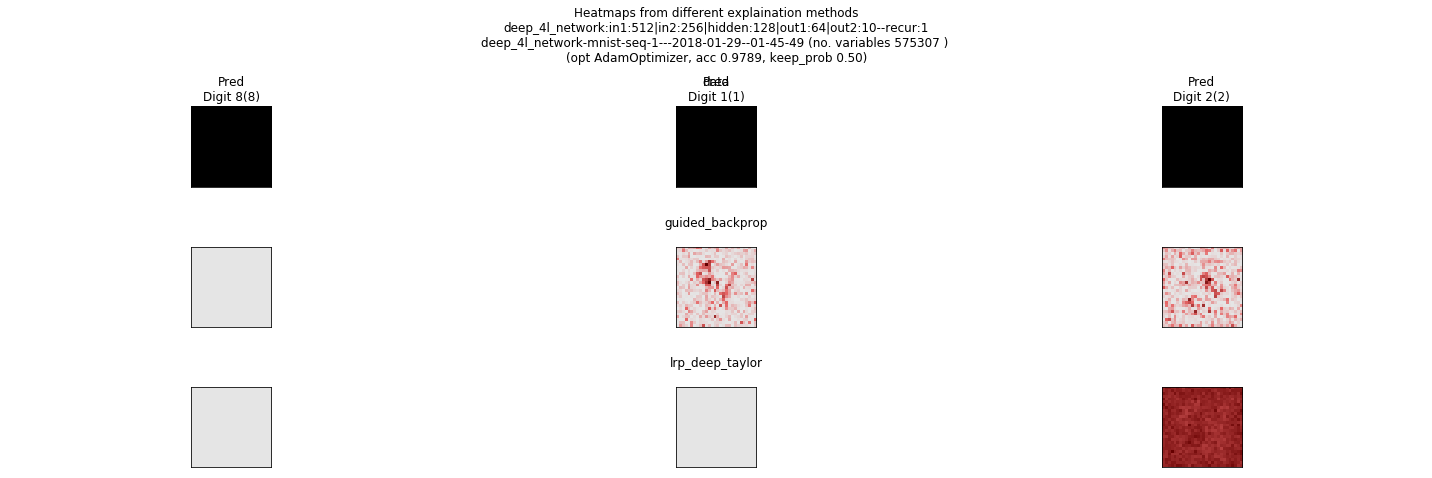

In [28]:
plot.plot_relevance_methods(model_path('deep_4l', 'mnist', 1), dataset['mnist'], data=(x,y),
                            methods=['guided_backprop', 'lrp_deep_taylor'], verbose=True) 

2018-02-01 09:57:23,889 | DEBUG : provider.py(load 10) - Load network from ../final-models/convdeep_4l_network-mnist-seq-1
2018-02-01 09:57:23,895 | DEBUG : experiment_artifact.py(get_result 68) - Getting result 
{'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9931666851043701, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 'convdeep_4l_network-mnist-seq-1---2018-01-29--23-20-56', 'architecture_name': 'convdeep_4l_network', 'accuracy': 0.9944000244140625, 'dims': 28, 'lr': 0.0001, 'keep_prob': 0.5, 'architecture': 'conv1:5x5x24=>2x2[2,2]|conv2:3x3x48=>2x2[2,2]|hidden:256|out1:128|out2:10--recur:1', 'column_at_a_time': 28, 'max_seq_length': 28, 'dataset': 'mnist', 'batch': 50}
2018-02-01 09:57:23,896 | DEBUG : experiment_artifact.py(get_result 69) - {'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9931666851043701, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 'convdeep_4l_network-mnist-seq-1---2018-01-29--23-20-56', 'architecture_name': '

Relevance score for 0  : 0.0000
Relevance score for 1  : 0.1891
Relevance score for 2  : 72.3635
Relevance score for 0  : 0.0000
Relevance score for 1  : 0.0000
Relevance score for 2  : 9.1801


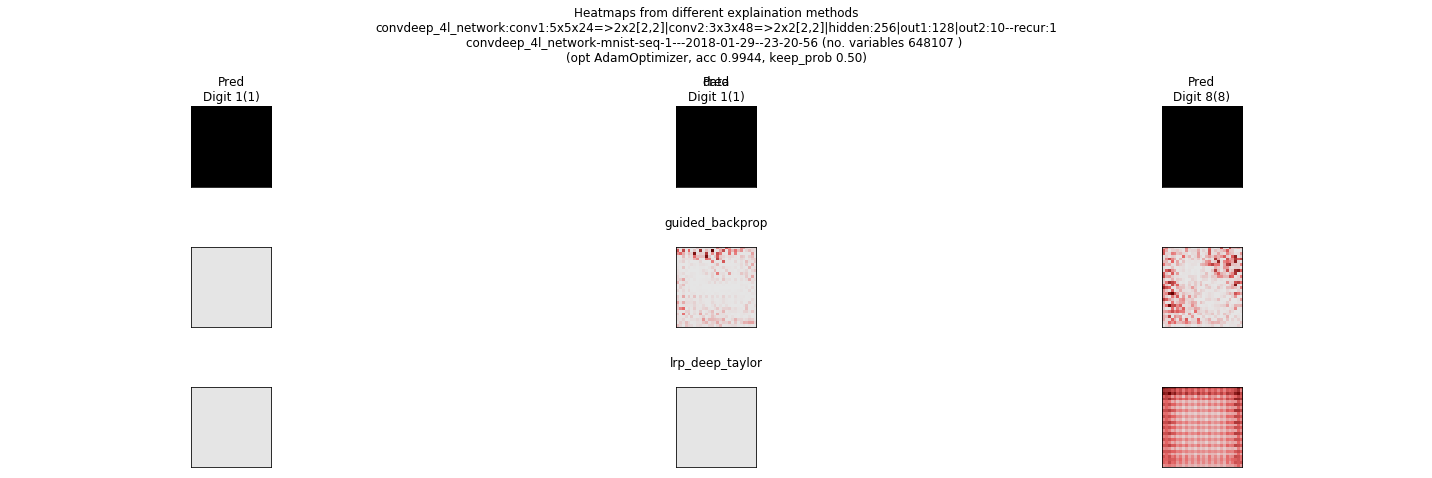

In [30]:
plot.plot_relevance_methods(model_path('convdeep_4l', 'mnist', 1), dataset['mnist'], data=(x,y),
                            methods=['guided_backprop', 'lrp_deep_taylor'], verbose=True) 

2018-02-01 09:56:39,340 | DEBUG : provider.py(load 10) - Load network from ../final-models/convdeep_4l_network-fashion-mnist-seq-1
2018-02-01 09:56:39,346 | DEBUG : experiment_artifact.py(get_result 68) - Getting result 
{'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9354166388511658, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 'convdeep_4l_network-fashion-mnist-seq-1---2018-01-30--20-29-56', 'architecture_name': 'convdeep_4l_network', 'accuracy': 0.9305999875068665, 'dims': 28, 'lr': 0.0001, 'keep_prob': 0.5, 'architecture': 'conv1:5x5x24=>2x2[2,2]|conv2:3x3x48=>2x2[2,2]|hidden:256|out1:128|out2:10--recur:1', 'column_at_a_time': 28, 'max_seq_length': 28, 'dataset': 'fashion-mnist', 'batch': 50}
2018-02-01 09:56:39,347 | DEBUG : experiment_artifact.py(get_result 69) - {'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9354166388511658, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 'convdeep_4l_network-fashion-mnist-seq-1---2018-01-30--2

Relevance score for 0  : 0.0000
Relevance score for 1  : 7.2007
Relevance score for 2  : 9.5222
Relevance score for 0  : 0.0000
Relevance score for 1  : 0.0000
Relevance score for 2  : 0.0000


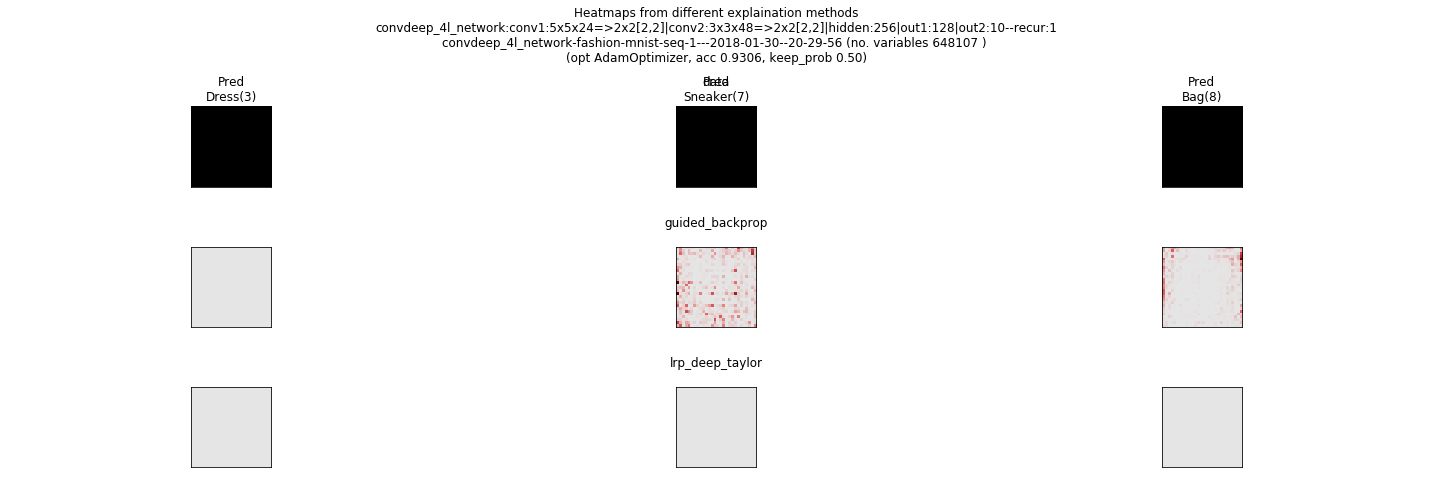

In [29]:
plot.plot_relevance_methods(model_path('convdeep_4l', 'fashion-mnist', 1), dataset['fashion-mnist'], data=(x,y),
                            methods=['guided_backprop', 'lrp_deep_taylor'], verbose=True) 

2018-01-27 23:32:48,945 | DEBUG : provider.py(load 10) - Load network from ../experiment-results/aws-training/convdeep_4l_artificial_output-fashion-mnist-seq-1---2018-01-25--11-32-53
2018-01-27 23:32:48,954 | DEBUG : experiment_artifact.py(get_result 68) - Getting result 
{'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9295833110809326, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 'convdeep_4l_artificial_output-fashion-mnist-seq-1---2018-01-25--11-32-53', 'architecture_name': 'convdeep_4l_network', 'accuracy': 0.9258999824523926, 'dims': 28, 'lr': 0.0001, 'keep_prob': 0.5, 'architecture': 'conv1:5x5x32=>2x2[2,2]|conv2:5x5x64=>2x2[2,2]|hidden:128|out1:64|out2:10--recur:1', 'column_at_a_time': 28, 'max_seq_length': 28, 'dataset': 'fashion-mnist', 'batch': 50}
2018-01-27 23:32:48,956 | DEBUG : experiment_artifact.py(get_result 69) - {'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9295833110809326, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_na

Relevance score for 0  : 0.0000
Relevance score for 1  : 12.0389
Relevance score for 2  : 7.9455
Relevance score for 0  : 0.0000
Relevance score for 1  : 0.2616
Relevance score for 2  : 0.7767


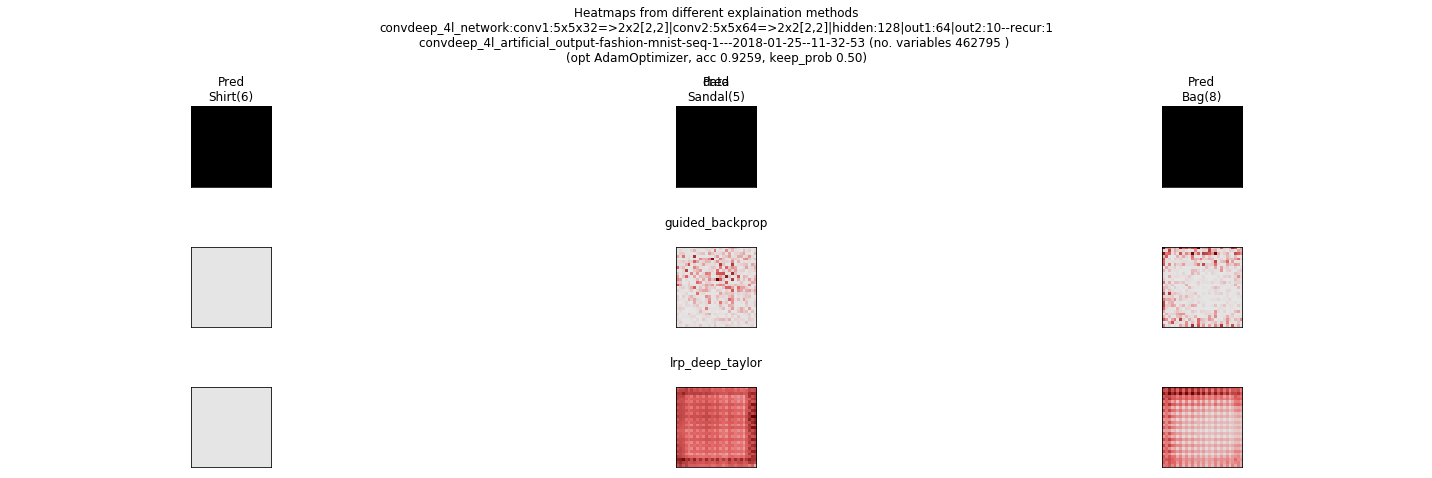

In [23]:
plot.plot_relevance_methods('../experiment-results/aws-training/convdeep_4l_artificial_output-fashion-mnist-seq-1---2018-01-25--11-32-53',
                            dataset['fashion-mnist'], data=(x,y),
                            methods=['guided_backprop', 'lrp_deep_taylor'], verbose=True) 

2018-01-27 23:33:48,323 | DEBUG : provider.py(load 10) - Load network from ../experiment-results/aws-training/convdeep_4l_artificial_output-fashion-mnist-seq-1---2018-01-27--13-37-13
2018-01-27 23:33:48,329 | DEBUG : experiment_artifact.py(get_result 68) - Getting result 
{'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9299166798591614, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'experiment_name': 'convdeep_4l_artificial_output-fashion-mnist-seq-1---2018-01-27--13-37-13', 'architecture_name': 'convdeep_4l_artificial_output', 'accuracy': 0.9277999997138977, 'dims': 28, 'lr': 0.0001, 'keep_prob': 0.5, 'architecture': 'conv1:5x5x32=>2x2[2,2]|conv2:5x5x64=>2x2[2,2]|hidden:128|out1:64|out2:10--recur:1', 'column_at_a_time': 28, 'max_seq_length': 28, 'dataset': 'fashion-mnist', 'batch': 50}
2018-01-27 23:33:48,330 | DEBUG : experiment_artifact.py(get_result 69) - {'optimizer': 'AdamOptimizer', 'val_accuracy': 0.9299166798591614, 'epoch': 200, 'regularizer': 0.0, 'seq_length': 1, 'exp

(?, 11)


2018-01-27 23:33:49,290 | INFO : base.py(rel_guided_backprop 141) - Explaining with guided_backprop
2018-01-27 23:33:49,339 | INFO : convdeep_4l_artificial_output.py(__init__ 47) - conv1 shape 
2018-01-27 23:33:49,340 | INFO : convdeep_4l_artificial_output.py(__init__ 48) - [-1, 28, 28, 32]
2018-01-27 23:33:49,343 | INFO : convdeep_4l_artificial_output.py(__init__ 52) - pool1 shape 
2018-01-27 23:33:49,344 | INFO : convdeep_4l_artificial_output.py(__init__ 53) - [-1, 14, 14, 32]
2018-01-27 23:33:49,350 | INFO : convdeep_4l_artificial_output.py(__init__ 57) - conv2 shape 
2018-01-27 23:33:49,350 | INFO : convdeep_4l_artificial_output.py(__init__ 58) - [-1, 14, 14, 64]
2018-01-27 23:33:49,354 | INFO : convdeep_4l_artificial_output.py(__init__ 63) - Output dims after conv and pooling layers
2018-01-27 23:33:49,356 | INFO : convdeep_4l_artificial_output.py(__init__ 64) - (1, 7, 7, 64)


(?, 11)


2018-01-27 23:33:51,525 | INFO : convdeep_4l_artificial_output.py(__init__ 47) - conv1 shape 
2018-01-27 23:33:51,526 | INFO : convdeep_4l_artificial_output.py(__init__ 48) - [-1, 28, 28, 32]
2018-01-27 23:33:51,529 | INFO : convdeep_4l_artificial_output.py(__init__ 52) - pool1 shape 
2018-01-27 23:33:51,530 | INFO : convdeep_4l_artificial_output.py(__init__ 53) - [-1, 14, 14, 32]
2018-01-27 23:33:51,535 | INFO : convdeep_4l_artificial_output.py(__init__ 57) - conv2 shape 
2018-01-27 23:33:51,536 | INFO : convdeep_4l_artificial_output.py(__init__ 58) - [-1, 14, 14, 64]
2018-01-27 23:33:51,539 | INFO : convdeep_4l_artificial_output.py(__init__ 63) - Output dims after conv and pooling layers
2018-01-27 23:33:51,540 | INFO : convdeep_4l_artificial_output.py(__init__ 64) - (1, 7, 7, 64)


(?, 11)


2018-01-27 23:33:52,588 | INFO : base.py(rel_lrp_deep_taylor 181) - Explaining with deep_taylor
2018-01-27 23:33:53,477 | DEBUG : base.py(_build_heatmap 234) - Prediction before softmax
2018-01-27 23:33:53,478 | DEBUG : base.py(_build_heatmap 235) - [[ -9.91868973e-03  -9.98867955e-03  -8.72974750e-03  -8.04871973e-03
   -8.55223462e-03  -1.18644526e-02  -8.48899875e-03  -8.03287420e-03
   -1.03874058e-02  -9.01911128e-03]
 [  9.98450089e+00   4.09376240e+00   3.91637874e+00   6.27037621e+00
    1.55721617e+00   1.14305487e+01   6.08449602e+00   1.38001842e+01
    1.25394592e+01   9.42159748e+00]
 [  1.12500591e+01   7.12771845e+00   4.80115557e+00   9.73363972e+00
    6.22332907e+00   8.56441689e+00   1.01413231e+01   7.52829027e+00
    1.66017818e+01   8.97951603e+00]]
2018-01-27 23:33:53,479 | DEBUG : base.py(_build_heatmap 236) - Relevance
2018-01-27 23:33:53,480 | DEBUG : base.py(_build_heatmap 237) - [  0.           9.98450089  11.25005913]


Relevance score for 0  : 0.0000
Relevance score for 1  : 55.6361
Relevance score for 2  : 37.0527
Relevance score for 0  : 0.0000
Relevance score for 1  : 9.9845
Relevance score for 2  : 11.2501


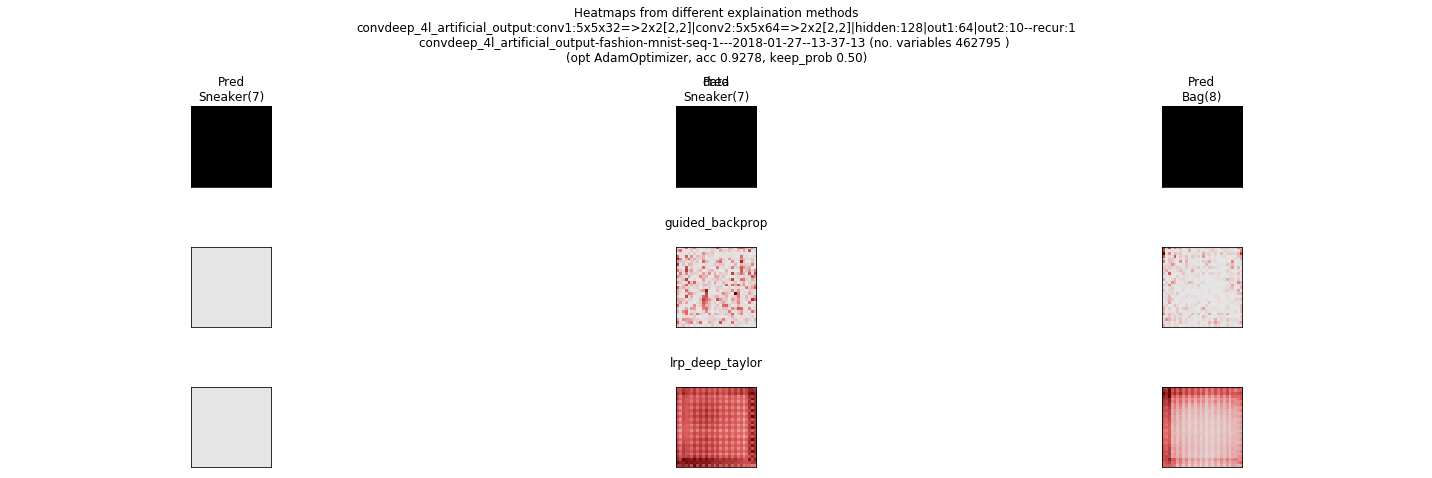

In [24]:
plot.plot_relevance_methods('../experiment-results/aws-training/convdeep_4l_artificial_output-fashion-mnist-seq-1---2018-01-27--13-37-13',
                            dataset['fashion-mnist'], data=(x,y),
                            methods=['guided_backprop', 'lrp_deep_taylor'], verbose=True) 

In [25]:
np

<module 'numpy' from '/Users/heytitle/projects/heatmapping-tutorial/venv/lib/python3.5/site-packages/numpy/__init__.py'>

In [27]:
np.trapz([1,1, -1, -1])

0.0